In [1]:
import datetime
import getpass

import cx_Oracle

class DbOra:
    
    connstr = '{username}/{password}@{hostname}:{port}/{database}'
#     oracle_connection_string = 'oracle+cx_oracle://' + \
#         '{username}:{password}@{hostname}:{port}/{database}'

    def __init__(self, username, password, hostname, sid, port=1521):
        self._username = username
        self._hostname = hostname
        self._sid = sid
        self._port = port
        self._connection = cx_Oracle.connect(
            DbOra.connstr.format(
                username=username,
                password=password,
                hostname=hostname,
                port=port,
                database=sid
            )
        )
        self._cursor = self._connection.cursor()
        self._cursor.arraysize = 50000
        
    @property
    def cursor(self):
        return self._cursor
    
    def stage_data(self, name, cnames, data):
        map_dtype_to_oratype = {
            str: 'VARCHAR2(256)',
            int: 'NUMBER',
            float: 'NUMBER',
            datetime.datetime: 'DATE'
        }
        ora_types = [map_dtype_to_oratype[type(x)] for x in data[0]]
        cols_str = ', '.join(['%s %s'%(cname, oratype)
                             for cname, oratype in zip(cnames, ora_types)])
        sql_create = 'create global temporary table %s (%s) on commit preserve rows'%(name, cols_str)
#         sql_create = 'create table %s (%s)'%(name, cols_str)
        
        ncols = len(data[0])
        bind_vars_str = ', '.join([':%d'%(i+1) for i in range(ncols)])
        sql_load = 'insert into %s (%s) values (%s)'%(name, ', '.join(list(cnames)), bind_vars_str)
        try:
            self._cursor.execute(sql_create)
        except cx_Oracle.DatabaseError as dberr:
            error, = dberr.args
            if error.code == 955:
                pass
            else:
                raise
        self._cursor.prepare(sql_load)
        self._cursor.executemany(None, data)
        
    def execute(self, sql):
        self._cursor.execute(sql)
            
    def query(self, sql):
        self._cursor.execute(sql)
        for rec in self._cursor:
            yield rec
            
    def get_column_names(self):
        return [x[0] for x in self._cursor.description]
        
    def commit(self):
        self._connection.commit()
        
    def rollback(self):
        self._connection.rollback()

    def __del__(self):
        self._connection.rollback()
        self._connection.close()

In [2]:
password_cdw = getpass.getpass('CDW Password:')
password_omop = getpass.getpass('OMOP Password:')

CDW Password:········
OMOP Password:········


In [3]:
def get_rxmap():
    db_cdw = DbOra('ephelps', password_cdw,
                   'hssc-cdwr3-dtdb-p', 'dtprd2')
    sql_rxmap = '''
        select distinct
          src_code, 'urn:hssc:musc:ndc|' || src_code cval, rxcui
        from (
            select
              src_code_type, src_code, rxcui,
              rank() over (partition by src_code_type, src_code
                           order by feed_type nulls last, rowid desc
                          ) as rnk
            from cdwref.ref_medcode
            where institution='MUSC'
              and deprecated='N'
              and rxcui is not null
              and src_code_type in ('MUSC_NDC')
        ) where rnk = 1
    '''
#     ('MUSC_MED_OP', 'MUSC_NDC')
    retval = list(db_cdw.query(sql_rxmap))
    del db_cdw
    return retval


def update_drug_exposures(rxmap):
    tname = 'omop_musc_rxmap_temp'
    cnames = ['src_code', 'cval', 'rxcui']
    db_omop = DbOra('omop_musc', password_omop,
                    'hssc-smilecdrdb-d', 'cdrdev')
    print('staging...', end='', flush=True)
    db_omop.stage_data(tname, cnames, rxmap)
    sql_concept_count = 'select count(1) from %s'%tname
    n_concepts = list(db_omop.query(sql_concept_count))[0][0]
    print('staged %d RxCUIs'%n_concepts, flush=True)
    sql_count = 'select count(1) from drug_exposure where drug_concept_id = 0'
    n_before = list(db_omop.query(sql_count))[0][0]
    print('%d unassigned records before merge'%n_before, flush=True)
#     sql_rxmap_to_concepts = '''
#         select c.concept_id, c.concept_code, m.cval
#         from concept c
#         inner join %s m
#           on (    c.concept_code = m.src_code
#               and c.domain_id = 'Drug'
#               and c.vocabulary_id like 'RxNorm%%' )'''%tname
#     rxmap = list(db_omop.execute(sql_rxmap_to_concepts))
    sql_merge = '''
        merge into drug_exposure tgt
        using (
            select c.concept_id, c.concept_code, m.cval
            from concept c
            inner join %s m
              on (    c.concept_code = m.rxcui
                  and c.domain_id = 'Drug'
                  and c.vocabulary_id in ('RxNorm', 'RxNorm Extension') )
        ) src on (tgt.drug_source_value = src.cval)
        when matched then update set
          tgt.drug_concept_id = src.concept_id'''%tname

    db_omop.execute(sql_merge)
    print('merge complete', flush=True)
    n_after = list(db_omop.query(sql_count))[0][0]
    print('%d unassigned records after merge'%n_after, flush=True)
    n_concepts = list(db_omop.query(sql_concept_count))[0][0]
    print('staged %d RxCUIs'%n_concepts, flush=True)
    db_omop.commit()
    print('committed', flush=True)
    del db_omop

In [11]:
%%time

update_drug_exposures(get_rxmap())

staging...staged 7137 RxCUIs
1222387 unassigned records before merge
merge complete
419384 unassigned records after merge
staged 7137 RxCUIs
committed
CPU times: user 57.6 ms, sys: 7.78 ms, total: 65.4 ms
Wall time: 47.3 s


In [7]:
rxmap = get_rxmap()

In [9]:
[rx for rx in rxmap if rx[0]=='54569-3899-0']

[('54569-3899-0', 'urn:hssc:musc:medicationcode|54569-3899-0', '630208')]

In [4]:
import csv

In [11]:
data = None
cols = None
with open('admin_code_map_from_desc.csv', 'r') as fin:
    rdr = csv.reader(fin, delimiter='|')
    data = [tuple(row) for row in rdr]
    cols = data.pop(0)

In [15]:
%%time

update_drug_exposures(data)

staging...staged 3252 RxCUIs
419384 unassigned records before merge
merge complete
265980 unassigned records after merge
staged 3252 RxCUIs
committed
CPU times: user 37.1 ms, sys: 1.5 ms, total: 38.6 ms
Wall time: 1min 2s


In [18]:
def get_summary():
    db_omop = DbOra('omop_musc', password_omop,
                    'hssc-smilecdrdb-d', 'cdrdev')
    sql_diagnostic = '''
        select
            drug_type_concept_id,
            cncpt2.concept_name,
            cncpt.concept_class_id,
            count(1) n_recs,
            round(100*count(1)/sum(count(1))
                    over (partition by drug_type_concept_id),
                  4) p_recs_by_type,
            round(100*count(1)/sum(count(1)) over (),
                  4) p_recs_of_all
        from drug_exposure de
        left outer join concept cncpt
            on (    de.drug_concept_id = cncpt.concept_id
                and cncpt.domain_id = 'Drug'
                and cncpt.vocabulary_id like 'RxNorm%' )
        left outer join concept cncpt2
            on (    de.drug_type_concept_id = cncpt2.concept_id
                and cncpt2.concept_class_id = 'Drug Type' )
        group by
            cncpt2.concept_name,
            drug_type_concept_id,
            cncpt.concept_class_id
        order by
            drug_type_concept_id,
            n_recs desc
    '''
    retval = list(db_omop.query(sql_diagnostic))
    del db_omop
    return retval

In [19]:
med_summ = get_summary()

In [21]:
import pandas as pd

In [23]:
df_summ = pd.DataFrame(med_summ, columns=['drug_type_concept_id',
                                          'drug_type', 'drug_class',
                                          'n_recs', 'p_recs_by_type', 'p_recs_of_all']
                      )
df_summ = df_summ[df_summ.columns[1:]]

In [25]:
df_summ.drug_class.unique()

array(['Clinical Drug', None, 'Quant Clinical Drug', 'Ingredient',
       'Branded Drug', 'Clinical Drug Comp', 'Quant Branded Drug',
       'Precise Ingredient', 'Clinical Pack', 'Clinical Drug Form',
       'Brand Name', 'Clinical Dose Group', 'Branded Pack',
       'Branded Drug Comp', 'Branded Drug Form', 'Dose Form'],
      dtype=object)

In [27]:
drug_type_map = { 'Prescription written': 'Order',
                  'Physician administered drug (identified as procedure)': 'Procedure',
                  'Inpatient administration': 'Admin' }
l_fully_specd = ['Clinical Drug', 'Quant Clinical Drug',
                 'Branded Drug', 'Quant Branded Drug',
                 'Clinical Pack', 'Branded Pack']
l_under_specd = ['Ingredient', 'Brand Name', 'Precise Ingredient',
                 'Clinical Drug Form', 'Clinical Dose Group', 'Branded Drug Comp',
                 'Branded Drug Form', 'Dose Form', 'Clinical Drug Comp']
def get_stat(dclass):
    if dclass in l_fully_specd:
        return 'Fully Specd'
    elif dclass in l_under_specd:
        return 'Under Specd'
    else:
        return 'Unresolved'

df_summ['source'] = df_summ.drug_type.apply(lambda x: drug_type_map[x])
df_summ['stat'] = df_summ.drug_class.apply(get_stat)

In [31]:
df_summ2 = df_summ[['source', 'stat', 'n_recs']]

In [32]:
df_summ2

source         stat  n_recs
0       Order  Fully Specd  921410
1       Order   Unresolved  223135
2       Order  Fully Specd  212209
3       Order  Under Specd   79092
4       Order  Fully Specd   38365
5       Order  Under Specd   19052
6       Order  Fully Specd   11839
7       Order  Under Specd    6930
8       Order  Fully Specd    6486
9       Order  Under Specd    3138
10      Order  Under Specd    1804
11      Order  Under Specd    1102
12      Order  Fully Specd     956
13      Order  Under Specd     133
14      Order  Under Specd      26
15      Order  Under Specd      16
16  Procedure   Unresolved   21253
17      Admin  Fully Specd  572865
18      Admin  Fully Specd  150132
19      Admin  Under Specd   70967
20      Admin  Fully Specd   47438
21      Admin   Unresolved   42845
22      Admin  Under Specd   17705
23      Admin  Fully Specd    6688
24      Admin  Under Specd    4059
25      Admin  Under Specd    2097
26      Admin  Under Specd    1118
27      Admin  Under Specd      96
28      Admin  Fully Specd      73
29      Admin  Under Specd      31
30      Admin  Under Specd       8

In [33]:
from edatls import tabular

In [ ]:
%matplotlib inline

In [42]:
df_summ3 = df_summ2.groupby(['source', 'stat']).sum().reset_index()

.


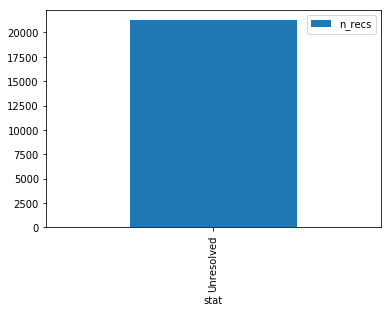

In [48]:
df_summ3.groupby('source').plot.bar('stat', 'n_recs')
print('.')

In [51]:
df_summ4 = df_summ3.merge(df_summ3.groupby(['source']).sum().reset_index(), left_on='source', right_on='source')

In [53]:
df_summ4['f_by_source'] = df_summ4.n_recs_x/df_summ4.n_recs_y
df_summ4['f_of_all'] = df_summ4.n_recs_x/df_summ4.n_recs_x.sum()

In [55]:
df_summ4.columns = ['source', 'stat', 'n_recs', 'dropme1', 'f_by_source', 'f_of_all']

In [56]:
df_summ4 = df_summ4.drop('dropme1', 1)

In [66]:
df_summ4.to_excel('test.xls')